In [1]:
import os
os.chdir("../..")

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from utils.dataset_loader import load_datasets
from utils.model_utils import initialize_model
from utils.train_utils import train_model
from utils.metrics import evaluate_model
from utils.visualization import (
    plot_training, 
    plot_confusion_matrix, 
    plot_precision_recall, 
    plot_roc_curve
)

In [3]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


In [4]:
# Model Name (Change this to test other models)
model_name = "mobilenet_v2"

In [5]:
# Directories
os.makedirs("outputs/models", exist_ok=True)
os.makedirs("outputs/plots", exist_ok=True)

In [6]:
# Load dataset with augmentation
print("[INFO] Loading augmented datasets...")
data_dir = "wildfire_dataset_scaled"
batch_size = 16
train_loader, val_loader, test_loader = load_datasets(
    data_dir, batch_size=batch_size, augmentation="augmented"
)
print("[INFO] Datasets loaded successfully!")


2024-12-21 20:55:27,950 - INFO - Loading datasets from wildfire_dataset_scaled with augmentation type 'augmented'.
2024-12-21 20:55:27,950 - INFO - Applying moderate augmentations: Flip, Rotate, and ColorJitter.
2024-12-21 20:55:27,958 - INFO - Initialized AlbumentationsDataset with root: wildfire_dataset_scaled/train
2024-12-21 20:55:27,960 - INFO - Initialized AlbumentationsDataset with root: wildfire_dataset_scaled/val
2024-12-21 20:55:27,961 - INFO - Initialized AlbumentationsDataset with root: wildfire_dataset_scaled/test
2024-12-21 20:55:27,962 - INFO - Datasets initialized. Preparing DataLoaders...
2024-12-21 20:55:27,963 - INFO - Using WeightedRandomSampler for class balancing.
2024-12-21 20:55:27,963 - INFO - Computing class weights from directory: wildfire_dataset_scaled/train
2024-12-21 20:55:27,964 - INFO - Class 'fire' has 730 samples.
2024-12-21 20:55:27,966 - INFO - Class 'nofire' has 1157 samples.
2024-12-21 20:55:27,966 - INFO - Computed class weights: {'fire': 2.58493

[INFO] Loading augmented datasets...


2024-12-21 20:55:29,878 - INFO - DataLoaders created successfully.


[INFO] Datasets loaded successfully!


In [7]:
def objective(trial):
    print(f"[DEBUG] Starting trial {trial.number}...")

    # Hyperparameter suggestions
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    dropout_prob = trial.suggest_float("dropout_prob", 0.2, 0.5)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "AdamW"])

    print(f"[DEBUG] Suggested hyperparameters: lr={lr}, weight_decay={weight_decay}, optimizer={optimizer_name}")

    # Initialize model
    model = initialize_model(
        model_name=model_name,
        num_classes=2,
        pretrained=True,
        freeze_all=False,
        dropout_prob=dropout_prob
    )
    model.to(device)

    # Optimizer setup
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=3, factor=0.5)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Train the model
    print("[INFO] Starting model training...")
    save_path = f"outputs/models/{model_name}_trial_best.pth"
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        save_path=save_path,
        early_stop_patience=5,
        monitor_metric="val_recall",
    )
    print("[INFO] Training completed!")

    # Return validation recall
    val_recall = history["val_recall"][-1]
    print(f"[INFO] Trial {trial.number} - Final Validation Recall: {val_recall:.4f}")
    return val_recall


In [8]:
# Run Optuna Hyperparameter Tuning
print("[INFO] Running hyperparameter optimization...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print(f"[INFO] Best parameters: {study.best_params}")

# Train the final model with the best parameters
print("[INFO] Training final model with best hyperparameters...")
final_model = initialize_model(
    model_name=model_name,
    num_classes=2,
    pretrained=True,
    freeze_all=False,  # All layers unfrozen
    dropout_prob=study.best_params["dropout_prob"]
)
final_model.to(device)

[I 2024-12-21 20:55:29,902] A new study created in memory with name: no-name-058be754-463b-4863-9f2b-fff94837d843


[INFO] Running hyperparameter optimization...
[DEBUG] Starting trial 0...
[DEBUG] Suggested hyperparameters: lr=0.0035507816378201485, weight_decay=7.162508164524767e-06, optimizer=Adam
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.003551
[INFO] Best model saved with val_recall: 0.7480
Epoch [1]: Train Loss: 0.5894, Train Acc: 0.7371 | Val Loss: 0.6225, Val Acc: 0.6816, Val Recall: 0.7480, Val F1: 0.7419


[INFO] Learning rate adjusted to: 0.003551
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [2]: Train Loss: 0.4338, Train Acc: 0.8124 | Val Loss: 0.5558, Val Acc: 0.7612, Val Recall: 0.7317, Val F1: 0.7895


[INFO] Learning rate adjusted to: 0.003551
[INFO] Best model saved with val_recall: 0.9593
Epoch [3]: Train Loss: 0.3458, Train Acc: 0.8564 | Val Loss: 0.4593, Val Acc: 0.8035, Val Recall: 0.9593, Val F1: 0.8566


[INFO] Learning rate adjusted to: 0.003551
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [4]: Train Loss: 0.3404, Train Acc: 0.8490 | Val Loss: 0.5647, Val Acc: 0.7687, Val Recall: 0.9268, Val F1: 0.8306


[INFO] Learning rate adjusted to: 0.001775
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [5]: Train Loss: 0.3615, Train Acc: 0.8521 | Val Loss: 0.4341, Val Acc: 0.8109, Val Recall: 0.8171, Val F1: 0.8410


[INFO] Learning rate adjusted to: 0.001775
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [6]: Train Loss: 0.2901, Train Acc: 0.8824 | Val Loss: 0.3379, Val Acc: 0.8557, Val Recall: 0.9146, Val F1: 0.8858


[INFO] Learning rate adjusted to: 0.001775
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [7]: Train Loss: 0.2311, Train Acc: 0.9120 | Val Loss: 0.3558, Val Acc: 0.8408, Val Recall: 0.8049, Val F1: 0.8609


[I 2024-12-21 20:56:35,928] Trial 0 finished with value: 0.9024390243902439 and parameters: {'lr': 0.0035507816378201485, 'weight_decay': 7.162508164524767e-06, 'dropout_prob': 0.25044976430248117, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.9024390243902439.


[INFO] Learning rate adjusted to: 0.001775
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [8]: Train Loss: 0.1818, Train Acc: 0.9316 | Val Loss: 0.3223, Val Acc: 0.8806, Val Recall: 0.9024, Val F1: 0.9024
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 8 epochs. Best val_recall: 0.9593

[INFO] Training completed!
[INFO] Trial 0 - Final Validation Recall: 0.9024
[DEBUG] Starting trial 1...
[DEBUG] Suggested hyperparameters: lr=1.3960519769052455e-05, weight_decay=8.60115318951135e-06, optimizer=SGD
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000014
[INFO] Best model saved with val_recall: 0.5244
Epoch [1]: Train Loss: 0.7041, Train Acc: 0.4881 | Val Loss: 0.6999, Val Acc: 0.4950, Val Recall: 0.5244, Val F1: 0.5597


[INFO] Learning rate adjusted to: 0.000014
[INFO] Best model saved with val_recall: 0.5528
Epoch [2]: Train Loss: 0.6995, Train Acc: 0.4854 | Val Loss: 0.6881, Val Acc: 0.5323, Val Recall: 0.5528, Val F1: 0.5913


[INFO] Learning rate adjusted to: 0.000014
[INFO] Best model saved with val_recall: 0.5732
Epoch [3]: Train Loss: 0.6918, Train Acc: 0.5204 | Val Loss: 0.6815, Val Acc: 0.5945, Val Recall: 0.5732, Val F1: 0.6337


[INFO] Learning rate adjusted to: 0.000014
[INFO] Best model saved with val_recall: 0.6016
Epoch [4]: Train Loss: 0.6869, Train Acc: 0.5480 | Val Loss: 0.6783, Val Acc: 0.5871, Val Recall: 0.6016, Val F1: 0.6407


[INFO] Learning rate adjusted to: 0.000007
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [5]: Train Loss: 0.6756, Train Acc: 0.5776 | Val Loss: 0.6735, Val Acc: 0.5945, Val Recall: 0.5528, Val F1: 0.6253


[INFO] Learning rate adjusted to: 0.000007
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [6]: Train Loss: 0.6734, Train Acc: 0.5877 | Val Loss: 0.6743, Val Acc: 0.6045, Val Recall: 0.5569, Val F1: 0.6328


[INFO] Learning rate adjusted to: 0.000007
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [7]: Train Loss: 0.6681, Train Acc: 0.6015 | Val Loss: 0.6668, Val Acc: 0.5995, Val Recall: 0.5650, Val F1: 0.6333


[INFO] Learning rate adjusted to: 0.000007
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [8]: Train Loss: 0.6673, Train Acc: 0.6036 | Val Loss: 0.6642, Val Acc: 0.6294, Val Recall: 0.5976, Val F1: 0.6637


[I 2024-12-21 20:57:47,810] Trial 1 finished with value: 0.540650406504065 and parameters: {'lr': 1.3960519769052455e-05, 'weight_decay': 8.60115318951135e-06, 'dropout_prob': 0.2806589485844454, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.9024390243902439.


[INFO] Learning rate adjusted to: 0.000003
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [9]: Train Loss: 0.6638, Train Acc: 0.6073 | Val Loss: 0.6669, Val Acc: 0.6144, Val Recall: 0.5407, Val F1: 0.6318
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 9 epochs. Best val_recall: 0.6016

[INFO] Training completed!
[INFO] Trial 1 - Final Validation Recall: 0.5407
[DEBUG] Starting trial 2...
[DEBUG] Suggested hyperparameters: lr=0.00013048808484815202, weight_decay=2.311055634534777e-06, optimizer=AdamW
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000130
[INFO] Best model saved with val_recall: 0.9146
Epoch [1]: Train Loss: 0.4314, Train Acc: 0.8129 | Val Loss: 0.3088, Val Acc: 0.8731, Val Recall: 0.9146, Val F1: 0.8982


[INFO] Learning rate adjusted to: 0.000130
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [2]: Train Loss: 0.2444, Train Acc: 0.9009 | Val Loss: 0.2207, Val Acc: 0.9080, Val Recall: 0.9065, Val F1: 0.9234


[INFO] Learning rate adjusted to: 0.000130
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [3]: Train Loss: 0.1746, Train Acc: 0.9401 | Val Loss: 0.3021, Val Acc: 0.8806, Val Recall: 0.8780, Val F1: 0.9000


[INFO] Learning rate adjusted to: 0.000130
[INFO] Best model saved with val_recall: 0.9309
Epoch [4]: Train Loss: 0.1396, Train Acc: 0.9459 | Val Loss: 0.2238, Val Acc: 0.9055, Val Recall: 0.9309, Val F1: 0.9234


[INFO] Learning rate adjusted to: 0.000065
[INFO] Best model saved with val_recall: 0.9431
Epoch [5]: Train Loss: 0.1134, Train Acc: 0.9592 | Val Loss: 0.2523, Val Acc: 0.8955, Val Recall: 0.9431, Val F1: 0.9170


[INFO] Learning rate adjusted to: 0.000065
[INFO] Best model saved with val_recall: 0.9512
Epoch [6]: Train Loss: 0.0759, Train Acc: 0.9724 | Val Loss: 0.2389, Val Acc: 0.9129, Val Recall: 0.9512, Val F1: 0.9304


[INFO] Learning rate adjusted to: 0.000065
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [7]: Train Loss: 0.0658, Train Acc: 0.9815 | Val Loss: 0.2232, Val Acc: 0.9129, Val Recall: 0.9512, Val F1: 0.9304


[INFO] Learning rate adjusted to: 0.000065
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [8]: Train Loss: 0.0506, Train Acc: 0.9873 | Val Loss: 0.2509, Val Acc: 0.8980, Val Recall: 0.9431, Val F1: 0.9188


[INFO] Learning rate adjusted to: 0.000033
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [9]: Train Loss: 0.0670, Train Acc: 0.9777 | Val Loss: 0.2475, Val Acc: 0.9303, Val Recall: 0.9512, Val F1: 0.9435


[INFO] Learning rate adjusted to: 0.000033
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [10]: Train Loss: 0.0518, Train Acc: 0.9841 | Val Loss: 0.2248, Val Acc: 0.9229, Val Recall: 0.9512, Val F1: 0.9379


[I 2024-12-21 20:59:17,977] Trial 2 finished with value: 0.9471544715447154 and parameters: {'lr': 0.00013048808484815202, 'weight_decay': 2.311055634534777e-06, 'dropout_prob': 0.44843974304028755, 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.9471544715447154.


[INFO] Learning rate adjusted to: 0.000033
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [11]: Train Loss: 0.0449, Train Acc: 0.9852 | Val Loss: 0.2285, Val Acc: 0.9279, Val Recall: 0.9472, Val F1: 0.9414
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 11 epochs. Best val_recall: 0.9512

[INFO] Training completed!
[INFO] Trial 2 - Final Validation Recall: 0.9472
[DEBUG] Starting trial 3...
[DEBUG] Suggested hyperparameters: lr=0.003363205643101231, weight_decay=2.5749116992394057e-06, optimizer=Adam
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.003363
[INFO] Best model saved with val_recall: 0.8049
Epoch [1]: Train Loss: 0.5919, Train Acc: 0.7255 | Val Loss: 0.5929, Val Acc: 0.7512, Val Recall: 0.8049, Val F1: 0.7984


[INFO] Learning rate adjusted to: 0.003363
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [2]: Train Loss: 0.4535, Train Acc: 0.7986 | Val Loss: 0.5286, Val Acc: 0.7960, Val Recall: 0.7317, Val F1: 0.8145


[INFO] Learning rate adjusted to: 0.003363
[INFO] Best model saved with val_recall: 0.9024
Epoch [3]: Train Loss: 0.4068, Train Acc: 0.8272 | Val Loss: 0.3998, Val Acc: 0.8209, Val Recall: 0.9024, Val F1: 0.8605


[INFO] Learning rate adjusted to: 0.003363
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [4]: Train Loss: 0.3631, Train Acc: 0.8474 | Val Loss: 0.7160, Val Acc: 0.6269, Val Recall: 0.4675, Val F1: 0.6053


[INFO] Learning rate adjusted to: 0.003363
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [5]: Train Loss: 0.3395, Train Acc: 0.8596 | Val Loss: 0.5145, Val Acc: 0.7910, Val Recall: 0.8171, Val F1: 0.8272


[INFO] Learning rate adjusted to: 0.003363
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [6]: Train Loss: 0.3542, Train Acc: 0.8580 | Val Loss: 0.3469, Val Acc: 0.8433, Val Recall: 0.8455, Val F1: 0.8685


[INFO] Learning rate adjusted to: 0.003363
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [7]: Train Loss: 0.3406, Train Acc: 0.8559 | Val Loss: 0.3932, Val Acc: 0.8483, Val Recall: 0.8862, Val F1: 0.8773


[I 2024-12-21 21:00:21,949] Trial 3 finished with value: 0.8821138211382114 and parameters: {'lr': 0.003363205643101231, 'weight_decay': 2.5749116992394057e-06, 'dropout_prob': 0.41237328200111184, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.9471544715447154.


[INFO] Learning rate adjusted to: 0.001682
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [8]: Train Loss: 0.3340, Train Acc: 0.8580 | Val Loss: 0.3453, Val Acc: 0.8408, Val Recall: 0.8821, Val F1: 0.8715
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 8 epochs. Best val_recall: 0.9024

[INFO] Training completed!
[INFO] Trial 3 - Final Validation Recall: 0.8821
[DEBUG] Starting trial 4...
[DEBUG] Suggested hyperparameters: lr=3.735852306697068e-05, weight_decay=3.963803598954111e-05, optimizer=SGD
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000037
[INFO] Best model saved with val_recall: 0.5935
Epoch [1]: Train Loss: 0.6828, Train Acc: 0.5559 | Val Loss: 0.6745, Val Acc: 0.5945, Val Recall: 0.5935, Val F1: 0.6418


[INFO] Learning rate adjusted to: 0.000037
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [2]: Train Loss: 0.6711, Train Acc: 0.5819 | Val Loss: 0.6647, Val Acc: 0.6219, Val Recall: 0.5569, Val F1: 0.6432


[INFO] Learning rate adjusted to: 0.000037
[INFO] Best model saved with val_recall: 0.6585
Epoch [3]: Train Loss: 0.6563, Train Acc: 0.6216 | Val Loss: 0.6497, Val Acc: 0.6567, Val Recall: 0.6585, Val F1: 0.7013


[INFO] Learning rate adjusted to: 0.000037
[INFO] Best model saved with val_recall: 0.6789
Epoch [4]: Train Loss: 0.6395, Train Acc: 0.6704 | Val Loss: 0.6356, Val Acc: 0.7164, Val Recall: 0.6789, Val F1: 0.7455


[INFO] Learning rate adjusted to: 0.000019
[INFO] Best model saved with val_recall: 0.7236
Epoch [5]: Train Loss: 0.6230, Train Acc: 0.7022 | Val Loss: 0.6224, Val Acc: 0.7264, Val Recall: 0.7236, Val F1: 0.7639


[INFO] Learning rate adjusted to: 0.000019
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [6]: Train Loss: 0.6168, Train Acc: 0.7027 | Val Loss: 0.6215, Val Acc: 0.6990, Val Recall: 0.6341, Val F1: 0.7206


[INFO] Learning rate adjusted to: 0.000019
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [7]: Train Loss: 0.6073, Train Acc: 0.7223 | Val Loss: 0.6119, Val Acc: 0.7388, Val Recall: 0.7073, Val F1: 0.7682


[INFO] Learning rate adjusted to: 0.000019
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [8]: Train Loss: 0.5993, Train Acc: 0.7350 | Val Loss: 0.6078, Val Acc: 0.7090, Val Recall: 0.6992, Val F1: 0.7462


[INFO] Learning rate adjusted to: 0.000009
[INFO] Best model saved with val_recall: 0.7642
Epoch [9]: Train Loss: 0.5960, Train Acc: 0.7287 | Val Loss: 0.5971, Val Acc: 0.7463, Val Recall: 0.7642, Val F1: 0.7866


[INFO] Learning rate adjusted to: 0.000009
[INFO] Best model saved with val_recall: 0.7805
Epoch [10]: Train Loss: 0.5893, Train Acc: 0.7329 | Val Loss: 0.5908, Val Acc: 0.7488, Val Recall: 0.7805, Val F1: 0.7918


[INFO] Learning rate adjusted to: 0.000009
[INFO] Best model saved with val_recall: 0.7967
Epoch [11]: Train Loss: 0.5856, Train Acc: 0.7451 | Val Loss: 0.5863, Val Acc: 0.7637, Val Recall: 0.7967, Val F1: 0.8049


[INFO] Learning rate adjusted to: 0.000009
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [12]: Train Loss: 0.5814, Train Acc: 0.7536 | Val Loss: 0.5856, Val Acc: 0.7512, Val Recall: 0.7642, Val F1: 0.7899


[INFO] Learning rate adjusted to: 0.000005
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [13]: Train Loss: 0.5757, Train Acc: 0.7520 | Val Loss: 0.5794, Val Acc: 0.7662, Val Recall: 0.7642, Val F1: 0.8000


[INFO] Learning rate adjusted to: 0.000005
[INFO] Best model saved with val_recall: 0.8089
Epoch [14]: Train Loss: 0.5870, Train Acc: 0.7424 | Val Loss: 0.5810, Val Acc: 0.7761, Val Recall: 0.8089, Val F1: 0.8156


[INFO] Learning rate adjusted to: 0.000005
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [15]: Train Loss: 0.5725, Train Acc: 0.7631 | Val Loss: 0.5838, Val Acc: 0.7512, Val Recall: 0.7683, Val F1: 0.7908


[INFO] Learning rate adjusted to: 0.000005
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [16]: Train Loss: 0.5852, Train Acc: 0.7334 | Val Loss: 0.5816, Val Acc: 0.7612, Val Recall: 0.7724, Val F1: 0.7983


[INFO] Learning rate adjusted to: 0.000002
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [17]: Train Loss: 0.5795, Train Acc: 0.7424 | Val Loss: 0.5809, Val Acc: 0.7363, Val Recall: 0.7683, Val F1: 0.7810


[INFO] Learning rate adjusted to: 0.000002
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [18]: Train Loss: 0.5686, Train Acc: 0.7636 | Val Loss: 0.5826, Val Acc: 0.7289, Val Recall: 0.7154, Val F1: 0.7636


[INFO] Learning rate adjusted to: 0.000002
[INFO] Best model saved with val_recall: 0.8374
Epoch [19]: Train Loss: 0.5856, Train Acc: 0.7409 | Val Loss: 0.5673, Val Acc: 0.8010, Val Recall: 0.8374, Val F1: 0.8374


[INFO] Learning rate adjusted to: 0.000002
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [20]: Train Loss: 0.5766, Train Acc: 0.7435 | Val Loss: 0.5682, Val Acc: 0.8010, Val Recall: 0.8008, Val F1: 0.8312


[INFO] Learning rate adjusted to: 0.000001
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [21]: Train Loss: 0.5735, Train Acc: 0.7525 | Val Loss: 0.5751, Val Acc: 0.7786, Val Recall: 0.7805, Val F1: 0.8118


[INFO] Learning rate adjusted to: 0.000001
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [22]: Train Loss: 0.5677, Train Acc: 0.7652 | Val Loss: 0.5781, Val Acc: 0.7612, Val Recall: 0.7683, Val F1: 0.7975


[INFO] Learning rate adjusted to: 0.000001
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [23]: Train Loss: 0.5718, Train Acc: 0.7636 | Val Loss: 0.5689, Val Acc: 0.7811, Val Recall: 0.8008, Val F1: 0.8174


[I 2024-12-21 21:03:32,316] Trial 4 finished with value: 0.7723577235772358 and parameters: {'lr': 3.735852306697068e-05, 'weight_decay': 3.963803598954111e-05, 'dropout_prob': 0.416553967993759, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.9471544715447154.


[INFO] Learning rate adjusted to: 0.000001
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [24]: Train Loss: 0.5705, Train Acc: 0.7689 | Val Loss: 0.5764, Val Acc: 0.7736, Val Recall: 0.7724, Val F1: 0.8068
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 24 epochs. Best val_recall: 0.8374

[INFO] Training completed!
[INFO] Trial 4 - Final Validation Recall: 0.7724
[DEBUG] Starting trial 5...
[DEBUG] Suggested hyperparameters: lr=0.00030555735117121524, weight_decay=0.0002531993527623813, optimizer=Adam
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000306
[INFO] Best model saved with val_recall: 0.9431
Epoch [1]: Train Loss: 0.3443, Train Acc: 0.8394 | Val Loss: 0.3062, Val Acc: 0.8657, Val Recall: 0.9431, Val F1: 0.8958


[INFO] Learning rate adjusted to: 0.000306
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [2]: Train Loss: 0.2120, Train Acc: 0.9232 | Val Loss: 0.2748, Val Acc: 0.8955, Val Recall: 0.8902, Val F1: 0.9125


[INFO] Learning rate adjusted to: 0.000306
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [3]: Train Loss: 0.1297, Train Acc: 0.9502 | Val Loss: 0.2852, Val Acc: 0.9005, Val Recall: 0.9187, Val F1: 0.9187


[INFO] Learning rate adjusted to: 0.000306
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [4]: Train Loss: 0.1140, Train Acc: 0.9597 | Val Loss: 0.2183, Val Acc: 0.9055, Val Recall: 0.9065, Val F1: 0.9215


[INFO] Learning rate adjusted to: 0.000306
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [5]: Train Loss: 0.1086, Train Acc: 0.9576 | Val Loss: 0.3429, Val Acc: 0.9154, Val Recall: 0.9431, Val F1: 0.9317


[I 2024-12-21 21:04:23,020] Trial 5 finished with value: 0.9065040650406504 and parameters: {'lr': 0.00030555735117121524, 'weight_decay': 0.0002531993527623813, 'dropout_prob': 0.4967134580748365, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.9471544715447154.


[INFO] Learning rate adjusted to: 0.000306
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [6]: Train Loss: 0.1022, Train Acc: 0.9677 | Val Loss: 0.3012, Val Acc: 0.9055, Val Recall: 0.9065, Val F1: 0.9215
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 6 epochs. Best val_recall: 0.9431

[INFO] Training completed!
[INFO] Trial 5 - Final Validation Recall: 0.9065
[DEBUG] Starting trial 6...
[DEBUG] Suggested hyperparameters: lr=2.0838919140047486e-05, weight_decay=3.1796069214582835e-05, optimizer=Adam
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000021
[INFO] Best model saved with val_recall: 0.7967
Epoch [1]: Train Loss: 0.6455, Train Acc: 0.6476 | Val Loss: 0.5868, Val Acc: 0.7537, Val Recall: 0.7967, Val F1: 0.7984


[INFO] Learning rate adjusted to: 0.000021
[INFO] Best model saved with val_recall: 0.8415
Epoch [2]: Train Loss: 0.5210, Train Acc: 0.7907 | Val Loss: 0.4716, Val Acc: 0.8234, Val Recall: 0.8415, Val F1: 0.8536


[INFO] Learning rate adjusted to: 0.000021
[INFO] Best model saved with val_recall: 0.8659
Epoch [3]: Train Loss: 0.4226, Train Acc: 0.8325 | Val Loss: 0.3994, Val Acc: 0.8383, Val Recall: 0.8659, Val F1: 0.8676


[INFO] Learning rate adjusted to: 0.000021
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [4]: Train Loss: 0.3350, Train Acc: 0.8686 | Val Loss: 0.3621, Val Acc: 0.8582, Val Recall: 0.8577, Val F1: 0.8810


[INFO] Learning rate adjusted to: 0.000010
[INFO] Best model saved with val_recall: 0.9024
Epoch [5]: Train Loss: 0.3054, Train Acc: 0.8802 | Val Loss: 0.3120, Val Acc: 0.8682, Val Recall: 0.9024, Val F1: 0.8934


[INFO] Learning rate adjusted to: 0.000010
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [6]: Train Loss: 0.2846, Train Acc: 0.8898 | Val Loss: 0.3098, Val Acc: 0.8706, Val Recall: 0.8862, Val F1: 0.8934


[INFO] Learning rate adjusted to: 0.000010
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [7]: Train Loss: 0.2571, Train Acc: 0.9009 | Val Loss: 0.2966, Val Acc: 0.8905, Val Recall: 0.8984, Val F1: 0.9095


[INFO] Learning rate adjusted to: 0.000010
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [8]: Train Loss: 0.2550, Train Acc: 0.9030 | Val Loss: 0.2902, Val Acc: 0.8856, Val Recall: 0.9024, Val F1: 0.9061


[INFO] Learning rate adjusted to: 0.000005
[INFO] Best model saved with val_recall: 0.9187
Epoch [9]: Train Loss: 0.2450, Train Acc: 0.9057 | Val Loss: 0.2716, Val Acc: 0.9030, Val Recall: 0.9187, Val F1: 0.9206


[INFO] Learning rate adjusted to: 0.000005
[INFO] Best model saved with val_recall: 0.9228
Epoch [10]: Train Loss: 0.2217, Train Acc: 0.9163 | Val Loss: 0.2527, Val Acc: 0.8881, Val Recall: 0.9228, Val F1: 0.9098


[INFO] Learning rate adjusted to: 0.000005
[INFO] Best model saved with val_recall: 0.9268
Epoch [11]: Train Loss: 0.2033, Train Acc: 0.9242 | Val Loss: 0.2445, Val Acc: 0.9030, Val Recall: 0.9268, Val F1: 0.9212


[INFO] Learning rate adjusted to: 0.000005
[INFO] Best model saved with val_recall: 0.9309
Epoch [12]: Train Loss: 0.2194, Train Acc: 0.9179 | Val Loss: 0.2547, Val Acc: 0.8881, Val Recall: 0.9309, Val F1: 0.9105


[INFO] Learning rate adjusted to: 0.000003
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [13]: Train Loss: 0.2188, Train Acc: 0.9115 | Val Loss: 0.2476, Val Acc: 0.9055, Val Recall: 0.9268, Val F1: 0.9231


[INFO] Learning rate adjusted to: 0.000003
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [14]: Train Loss: 0.2004, Train Acc: 0.9306 | Val Loss: 0.2487, Val Acc: 0.8980, Val Recall: 0.9309, Val F1: 0.9178


[INFO] Learning rate adjusted to: 0.000003
[INFO] Best model saved with val_recall: 0.9350
Epoch [15]: Train Loss: 0.2163, Train Acc: 0.9232 | Val Loss: 0.2437, Val Acc: 0.9055, Val Recall: 0.9350, Val F1: 0.9237


[INFO] Learning rate adjusted to: 0.000003
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [16]: Train Loss: 0.1988, Train Acc: 0.9279 | Val Loss: 0.2434, Val Acc: 0.8930, Val Recall: 0.9268, Val F1: 0.9138


[INFO] Learning rate adjusted to: 0.000001
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [17]: Train Loss: 0.2136, Train Acc: 0.9152 | Val Loss: 0.2584, Val Acc: 0.9005, Val Recall: 0.9187, Val F1: 0.9187


[INFO] Learning rate adjusted to: 0.000001
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [18]: Train Loss: 0.1988, Train Acc: 0.9327 | Val Loss: 0.2362, Val Acc: 0.9080, Val Recall: 0.9268, Val F1: 0.9249


[INFO] Learning rate adjusted to: 0.000001
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [19]: Train Loss: 0.1917, Train Acc: 0.9290 | Val Loss: 0.2533, Val Acc: 0.8930, Val Recall: 0.9268, Val F1: 0.9138


[I 2024-12-21 21:07:01,269] Trial 6 finished with value: 0.9308943089430894 and parameters: {'lr': 2.0838919140047486e-05, 'weight_decay': 3.1796069214582835e-05, 'dropout_prob': 0.35965418605578214, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.9471544715447154.


[INFO] Learning rate adjusted to: 0.000001
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [20]: Train Loss: 0.1905, Train Acc: 0.9258 | Val Loss: 0.2447, Val Acc: 0.9030, Val Recall: 0.9309, Val F1: 0.9215
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 20 epochs. Best val_recall: 0.9350

[INFO] Training completed!
[INFO] Trial 6 - Final Validation Recall: 0.9309
[DEBUG] Starting trial 7...
[DEBUG] Suggested hyperparameters: lr=0.0007424105747770249, weight_decay=3.422239556424755e-05, optimizer=Adam
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000742
[INFO] Best model saved with val_recall: 0.8943
Epoch [1]: Train Loss: 0.3358, Train Acc: 0.8612 | Val Loss: 0.3076, Val Acc: 0.8856, Val Recall: 0.8943, Val F1: 0.9053


[INFO] Learning rate adjusted to: 0.000742
[INFO] Best model saved with val_recall: 0.9472
Epoch [2]: Train Loss: 0.2333, Train Acc: 0.9099 | Val Loss: 0.2864, Val Acc: 0.8682, Val Recall: 0.9472, Val F1: 0.8979


[INFO] Learning rate adjusted to: 0.000742
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [3]: Train Loss: 0.1686, Train Acc: 0.9290 | Val Loss: 0.4590, Val Acc: 0.8582, Val Recall: 0.8415, Val F1: 0.8790


[INFO] Learning rate adjusted to: 0.000742
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [4]: Train Loss: 0.1886, Train Acc: 0.9359 | Val Loss: 0.3620, Val Acc: 0.8881, Val Recall: 0.8984, Val F1: 0.9076


[INFO] Learning rate adjusted to: 0.000742
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [5]: Train Loss: 0.1839, Train Acc: 0.9332 | Val Loss: 0.2560, Val Acc: 0.8955, Val Recall: 0.9065, Val F1: 0.9139


[INFO] Learning rate adjusted to: 0.000742
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [6]: Train Loss: 0.1739, Train Acc: 0.9338 | Val Loss: 0.2519, Val Acc: 0.9080, Val Recall: 0.9309, Val F1: 0.9253


[I 2024-12-21 21:07:56,205] Trial 7 finished with value: 0.943089430894309 and parameters: {'lr': 0.0007424105747770249, 'weight_decay': 3.422239556424755e-05, 'dropout_prob': 0.357910115427773, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.9471544715447154.


[INFO] Learning rate adjusted to: 0.000371
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [7]: Train Loss: 0.1262, Train Acc: 0.9512 | Val Loss: 0.3147, Val Acc: 0.9005, Val Recall: 0.9431, Val F1: 0.9206
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 7 epochs. Best val_recall: 0.9472

[INFO] Training completed!
[INFO] Trial 7 - Final Validation Recall: 0.9431
[DEBUG] Starting trial 8...
[DEBUG] Suggested hyperparameters: lr=1.997810821184401e-05, weight_decay=0.00019488762445601221, optimizer=SGD
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000020
[INFO] Best model saved with val_recall: 0.6870
Epoch [1]: Train Loss: 0.6997, Train Acc: 0.5082 | Val Loss: 0.6831, Val Acc: 0.5423, Val Recall: 0.6870, Val F1: 0.6475


[INFO] Learning rate adjusted to: 0.000020
[INFO] Best model saved with val_recall: 0.7317
Epoch [2]: Train Loss: 0.6849, Train Acc: 0.5485 | Val Loss: 0.6763, Val Acc: 0.5995, Val Recall: 0.7317, Val F1: 0.6910


[INFO] Learning rate adjusted to: 0.000020
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [3]: Train Loss: 0.6775, Train Acc: 0.5676 | Val Loss: 0.6748, Val Acc: 0.5995, Val Recall: 0.6585, Val F1: 0.6680


[INFO] Learning rate adjusted to: 0.000020
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [4]: Train Loss: 0.6762, Train Acc: 0.5766 | Val Loss: 0.6682, Val Acc: 0.6070, Val Recall: 0.5894, Val F1: 0.6473


[INFO] Learning rate adjusted to: 0.000010
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [5]: Train Loss: 0.6618, Train Acc: 0.6184 | Val Loss: 0.6564, Val Acc: 0.6567, Val Recall: 0.6423, Val F1: 0.6960


[INFO] Learning rate adjusted to: 0.000010
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [6]: Train Loss: 0.6561, Train Acc: 0.6370 | Val Loss: 0.6547, Val Acc: 0.6468, Val Recall: 0.6667, Val F1: 0.6979


[I 2024-12-21 21:08:50,746] Trial 8 finished with value: 0.6138211382113821 and parameters: {'lr': 1.997810821184401e-05, 'weight_decay': 0.00019488762445601221, 'dropout_prob': 0.2913788064390332, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.9471544715447154.


[INFO] Learning rate adjusted to: 0.000010
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [7]: Train Loss: 0.6541, Train Acc: 0.6407 | Val Loss: 0.6513, Val Acc: 0.6542, Val Recall: 0.6138, Val F1: 0.6848
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 7 epochs. Best val_recall: 0.7317

[INFO] Training completed!
[INFO] Trial 8 - Final Validation Recall: 0.6138
[DEBUG] Starting trial 9...
[DEBUG] Suggested hyperparameters: lr=0.0018037544207494757, weight_decay=0.00018499133767999317, optimizer=Adam
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.001804
[INFO] Best model saved with val_recall: 0.7846
Epoch [1]: Train Loss: 0.4510, Train Acc: 0.8013 | Val Loss: 0.4659, Val Acc: 0.8184, Val Recall: 0.7846, Val F1: 0.8410


[INFO] Learning rate adjusted to: 0.001804
[INFO] Best model saved with val_recall: 0.9390
Epoch [2]: Train Loss: 0.3521, Train Acc: 0.8484 | Val Loss: 0.3234, Val Acc: 0.8856, Val Recall: 0.9390, Val F1: 0.9094


[INFO] Learning rate adjusted to: 0.001804
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [3]: Train Loss: 0.3579, Train Acc: 0.8468 | Val Loss: 0.4466, Val Acc: 0.8209, Val Recall: 0.8699, Val F1: 0.8560


[INFO] Learning rate adjusted to: 0.001804
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [4]: Train Loss: 0.2942, Train Acc: 0.8771 | Val Loss: 0.4275, Val Acc: 0.8159, Val Recall: 0.8008, Val F1: 0.8419


[INFO] Learning rate adjusted to: 0.000902
[INFO] Best model saved with val_recall: 0.9512
Epoch [5]: Train Loss: 0.2586, Train Acc: 0.8977 | Val Loss: 0.3121, Val Acc: 0.8607, Val Recall: 0.9512, Val F1: 0.8931


[INFO] Learning rate adjusted to: 0.000902
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [6]: Train Loss: 0.1775, Train Acc: 0.9274 | Val Loss: 0.2581, Val Acc: 0.9080, Val Recall: 0.9309, Val F1: 0.9253


[INFO] Learning rate adjusted to: 0.000902
[INFO] Best model saved with val_recall: 0.9675
Epoch [7]: Train Loss: 0.1777, Train Acc: 0.9290 | Val Loss: 0.3935, Val Acc: 0.8557, Val Recall: 0.9675, Val F1: 0.8914


[INFO] Learning rate adjusted to: 0.000902
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [8]: Train Loss: 0.1657, Train Acc: 0.9343 | Val Loss: 0.3047, Val Acc: 0.8930, Val Recall: 0.9187, Val F1: 0.9131


[INFO] Learning rate adjusted to: 0.000451
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [9]: Train Loss: 0.1615, Train Acc: 0.9401 | Val Loss: 0.2787, Val Acc: 0.9055, Val Recall: 0.9187, Val F1: 0.9224


[INFO] Learning rate adjusted to: 0.000451
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [10]: Train Loss: 0.0986, Train Acc: 0.9677 | Val Loss: 0.3009, Val Acc: 0.9080, Val Recall: 0.9431, Val F1: 0.9261


[INFO] Learning rate adjusted to: 0.000451
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [11]: Train Loss: 0.0976, Train Acc: 0.9693 | Val Loss: 0.2814, Val Acc: 0.9179, Val Recall: 0.9512, Val F1: 0.9341


[I 2024-12-21 21:10:25,796] Trial 9 finished with value: 0.9146341463414634 and parameters: {'lr': 0.0018037544207494757, 'weight_decay': 0.00018499133767999317, 'dropout_prob': 0.2365558618683559, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.9471544715447154.


[INFO] Learning rate adjusted to: 0.000451
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [12]: Train Loss: 0.0784, Train Acc: 0.9709 | Val Loss: 0.2943, Val Acc: 0.9055, Val Recall: 0.9146, Val F1: 0.9221
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 12 epochs. Best val_recall: 0.9675

[INFO] Training completed!
[INFO] Trial 9 - Final Validation Recall: 0.9146
[DEBUG] Starting trial 10...
[DEBUG] Suggested hyperparameters: lr=0.0001206309194814509, weight_decay=1.0216568704683727e-06, optimizer=AdamW
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000121
[INFO] Best model saved with val_recall: 0.9472
Epoch [1]: Train Loss: 0.4667, Train Acc: 0.7848 | Val Loss: 0.3225, Val Acc: 0.8731, Val Recall: 0.9472, Val F1: 0.9014


[INFO] Learning rate adjusted to: 0.000121
[INFO] Best model saved with val_recall: 0.9512
Epoch [2]: Train Loss: 0.2436, Train Acc: 0.9110 | Val Loss: 0.2626, Val Acc: 0.9005, Val Recall: 0.9512, Val F1: 0.9213


[INFO] Learning rate adjusted to: 0.000121
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [3]: Train Loss: 0.1992, Train Acc: 0.9258 | Val Loss: 0.2777, Val Acc: 0.8930, Val Recall: 0.9024, Val F1: 0.9117


[INFO] Learning rate adjusted to: 0.000121
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [4]: Train Loss: 0.1425, Train Acc: 0.9481 | Val Loss: 0.2608, Val Acc: 0.9055, Val Recall: 0.9106, Val F1: 0.9218


[INFO] Learning rate adjusted to: 0.000060
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [5]: Train Loss: 0.1048, Train Acc: 0.9645 | Val Loss: 0.2573, Val Acc: 0.8955, Val Recall: 0.9146, Val F1: 0.9146


[INFO] Learning rate adjusted to: 0.000060
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [6]: Train Loss: 0.0804, Train Acc: 0.9762 | Val Loss: 0.2184, Val Acc: 0.9129, Val Recall: 0.9512, Val F1: 0.9304


[I 2024-12-21 21:11:21,088] Trial 10 finished with value: 0.9512195121951219 and parameters: {'lr': 0.0001206309194814509, 'weight_decay': 1.0216568704683727e-06, 'dropout_prob': 0.49502424413864854, 'optimizer': 'AdamW'}. Best is trial 10 with value: 0.9512195121951219.


[INFO] Learning rate adjusted to: 0.000060
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [7]: Train Loss: 0.0680, Train Acc: 0.9783 | Val Loss: 0.2478, Val Acc: 0.9030, Val Recall: 0.9512, Val F1: 0.9231
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 7 epochs. Best val_recall: 0.9512

[INFO] Training completed!
[INFO] Trial 10 - Final Validation Recall: 0.9512
[DEBUG] Starting trial 11...
[DEBUG] Suggested hyperparameters: lr=0.000125182365770675, weight_decay=1.04153518423797e-06, optimizer=AdamW
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000125
[INFO] Best model saved with val_recall: 0.9106
Epoch [1]: Train Loss: 0.4618, Train Acc: 0.7970 | Val Loss: 0.3411, Val Acc: 0.8557, Val Recall: 0.9106, Val F1: 0.8854


[INFO] Learning rate adjusted to: 0.000125
[INFO] Best model saved with val_recall: 0.9187
Epoch [2]: Train Loss: 0.2411, Train Acc: 0.9073 | Val Loss: 0.2407, Val Acc: 0.9005, Val Recall: 0.9187, Val F1: 0.9187


[INFO] Learning rate adjusted to: 0.000125
[INFO] Best model saved with val_recall: 0.9228
Epoch [3]: Train Loss: 0.1753, Train Acc: 0.9338 | Val Loss: 0.2499, Val Acc: 0.9055, Val Recall: 0.9228, Val F1: 0.9228


[INFO] Learning rate adjusted to: 0.000125
[INFO] Best model saved with val_recall: 0.9553
Epoch [4]: Train Loss: 0.1271, Train Acc: 0.9491 | Val Loss: 0.2157, Val Acc: 0.9179, Val Recall: 0.9553, Val F1: 0.9344


[INFO] Learning rate adjusted to: 0.000063
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [5]: Train Loss: 0.1167, Train Acc: 0.9603 | Val Loss: 0.2643, Val Acc: 0.9005, Val Recall: 0.9106, Val F1: 0.9180


[INFO] Learning rate adjusted to: 0.000063
[INFO] Best model saved with val_recall: 0.9593
Epoch [6]: Train Loss: 0.0687, Train Acc: 0.9777 | Val Loss: 0.1993, Val Acc: 0.9328, Val Recall: 0.9593, Val F1: 0.9459


[INFO] Learning rate adjusted to: 0.000063
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [7]: Train Loss: 0.0692, Train Acc: 0.9767 | Val Loss: 0.2169, Val Acc: 0.9179, Val Recall: 0.9512, Val F1: 0.9341


[INFO] Learning rate adjusted to: 0.000063
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [8]: Train Loss: 0.0706, Train Acc: 0.9772 | Val Loss: 0.2035, Val Acc: 0.9279, Val Recall: 0.9593, Val F1: 0.9421


[INFO] Learning rate adjusted to: 0.000031
[INFO] Best model saved with val_recall: 0.9634
Epoch [9]: Train Loss: 0.0587, Train Acc: 0.9809 | Val Loss: 0.2225, Val Acc: 0.9353, Val Recall: 0.9634, Val F1: 0.9480


[INFO] Learning rate adjusted to: 0.000031
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [10]: Train Loss: 0.0472, Train Acc: 0.9852 | Val Loss: 0.2276, Val Acc: 0.9303, Val Recall: 0.9553, Val F1: 0.9438


[INFO] Learning rate adjusted to: 0.000031
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [11]: Train Loss: 0.0435, Train Acc: 0.9841 | Val Loss: 0.2277, Val Acc: 0.9303, Val Recall: 0.9634, Val F1: 0.9442


[INFO] Learning rate adjusted to: 0.000031
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [12]: Train Loss: 0.0514, Train Acc: 0.9841 | Val Loss: 0.2185, Val Acc: 0.9303, Val Recall: 0.9593, Val F1: 0.9440


[INFO] Learning rate adjusted to: 0.000016
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [13]: Train Loss: 0.0396, Train Acc: 0.9868 | Val Loss: 0.2678, Val Acc: 0.9154, Val Recall: 0.9390, Val F1: 0.9315


[I 2024-12-21 21:13:11,768] Trial 11 finished with value: 0.9349593495934959 and parameters: {'lr': 0.000125182365770675, 'weight_decay': 1.04153518423797e-06, 'dropout_prob': 0.4984626579523138, 'optimizer': 'AdamW'}. Best is trial 10 with value: 0.9512195121951219.


[INFO] Learning rate adjusted to: 0.000016
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [14]: Train Loss: 0.0325, Train Acc: 0.9883 | Val Loss: 0.2691, Val Acc: 0.9229, Val Recall: 0.9350, Val F1: 0.9369
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 14 epochs. Best val_recall: 0.9634

[INFO] Training completed!
[INFO] Trial 11 - Final Validation Recall: 0.9350
[DEBUG] Starting trial 12...
[DEBUG] Suggested hyperparameters: lr=0.00010339317461775923, weight_decay=1.1027673711595416e-06, optimizer=AdamW
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000103
[INFO] Best model saved with val_recall: 0.8537
Epoch [1]: Train Loss: 0.4805, Train Acc: 0.7854 | Val Loss: 0.3509, Val Acc: 0.8433, Val Recall: 0.8537, Val F1: 0.8696


[INFO] Learning rate adjusted to: 0.000103
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [2]: Train Loss: 0.2516, Train Acc: 0.9104 | Val Loss: 0.3247, Val Acc: 0.8731, Val Recall: 0.8496, Val F1: 0.8913


[INFO] Learning rate adjusted to: 0.000103
[INFO] Best model saved with val_recall: 0.9553
Epoch [3]: Train Loss: 0.1875, Train Acc: 0.9322 | Val Loss: 0.2508, Val Acc: 0.9005, Val Recall: 0.9553, Val F1: 0.9216


[INFO] Learning rate adjusted to: 0.000103
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [4]: Train Loss: 0.1405, Train Acc: 0.9523 | Val Loss: 0.2369, Val Acc: 0.9129, Val Recall: 0.9187, Val F1: 0.9281


[INFO] Learning rate adjusted to: 0.000052
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [5]: Train Loss: 0.1189, Train Acc: 0.9544 | Val Loss: 0.2147, Val Acc: 0.9080, Val Recall: 0.9350, Val F1: 0.9256


[INFO] Learning rate adjusted to: 0.000052
[INFO] Best model saved with val_recall: 0.9593
Epoch [6]: Train Loss: 0.0986, Train Acc: 0.9656 | Val Loss: 0.2324, Val Acc: 0.9080, Val Recall: 0.9593, Val F1: 0.9273


[INFO] Learning rate adjusted to: 0.000052
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [7]: Train Loss: 0.0780, Train Acc: 0.9714 | Val Loss: 0.2290, Val Acc: 0.9229, Val Recall: 0.9390, Val F1: 0.9371


[INFO] Learning rate adjusted to: 0.000052
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [8]: Train Loss: 0.0743, Train Acc: 0.9762 | Val Loss: 0.2487, Val Acc: 0.9005, Val Recall: 0.9350, Val F1: 0.9200


[INFO] Learning rate adjusted to: 0.000026
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [9]: Train Loss: 0.0754, Train Acc: 0.9762 | Val Loss: 0.2369, Val Acc: 0.9154, Val Recall: 0.9350, Val F1: 0.9312


[INFO] Learning rate adjusted to: 0.000026
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [10]: Train Loss: 0.0639, Train Acc: 0.9799 | Val Loss: 0.2632, Val Acc: 0.9154, Val Recall: 0.9390, Val F1: 0.9315


[INFO] Learning rate adjusted to: 0.000026
[INFO] Best model saved with val_recall: 0.9634
Epoch [11]: Train Loss: 0.0651, Train Acc: 0.9762 | Val Loss: 0.2439, Val Acc: 0.9154, Val Recall: 0.9634, Val F1: 0.9331


[INFO] Learning rate adjusted to: 0.000026
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [12]: Train Loss: 0.0519, Train Acc: 0.9846 | Val Loss: 0.2420, Val Acc: 0.9104, Val Recall: 0.9350, Val F1: 0.9274


[INFO] Learning rate adjusted to: 0.000013
[INFO] Best model saved with val_recall: 0.9756
Epoch [13]: Train Loss: 0.0467, Train Acc: 0.9857 | Val Loss: 0.2796, Val Acc: 0.9154, Val Recall: 0.9756, Val F1: 0.9339


[INFO] Learning rate adjusted to: 0.000013
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [14]: Train Loss: 0.0319, Train Acc: 0.9905 | Val Loss: 0.2355, Val Acc: 0.9229, Val Recall: 0.9472, Val F1: 0.9376


[INFO] Learning rate adjusted to: 0.000013
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [15]: Train Loss: 0.0367, Train Acc: 0.9889 | Val Loss: 0.2464, Val Acc: 0.9229, Val Recall: 0.9512, Val F1: 0.9379


[INFO] Learning rate adjusted to: 0.000013
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [16]: Train Loss: 0.0489, Train Acc: 0.9809 | Val Loss: 0.2142, Val Acc: 0.9080, Val Recall: 0.9390, Val F1: 0.9259


[INFO] Learning rate adjusted to: 0.000006
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [17]: Train Loss: 0.0363, Train Acc: 0.9915 | Val Loss: 0.2415, Val Acc: 0.9179, Val Recall: 0.9512, Val F1: 0.9341


[I 2024-12-21 21:15:34,258] Trial 12 finished with value: 0.9552845528455285 and parameters: {'lr': 0.00010339317461775923, 'weight_decay': 1.1027673711595416e-06, 'dropout_prob': 0.44236501362762615, 'optimizer': 'AdamW'}. Best is trial 12 with value: 0.9552845528455285.


[INFO] Learning rate adjusted to: 0.000006
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [18]: Train Loss: 0.0462, Train Acc: 0.9852 | Val Loss: 0.2671, Val Acc: 0.9104, Val Recall: 0.9553, Val F1: 0.9289
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 18 epochs. Best val_recall: 0.9756

[INFO] Training completed!
[INFO] Trial 12 - Final Validation Recall: 0.9553
[DEBUG] Starting trial 13...
[DEBUG] Suggested hyperparameters: lr=7.564623763257574e-05, weight_decay=1.0040447754576711e-06, optimizer=AdamW
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000076
[INFO] Best model saved with val_recall: 0.8780
Epoch [1]: Train Loss: 0.5452, Train Acc: 0.7435 | Val Loss: 0.3929, Val Acc: 0.8408, Val Recall: 0.8780, Val F1: 0.8710


[INFO] Learning rate adjusted to: 0.000076
[INFO] Best model saved with val_recall: 0.9512
Epoch [2]: Train Loss: 0.3278, Train Acc: 0.8617 | Val Loss: 0.2738, Val Acc: 0.8806, Val Recall: 0.9512, Val F1: 0.9070


[INFO] Learning rate adjusted to: 0.000076
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [3]: Train Loss: 0.2373, Train Acc: 0.9168 | Val Loss: 0.2397, Val Acc: 0.9080, Val Recall: 0.9187, Val F1: 0.9243


[INFO] Learning rate adjusted to: 0.000076
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [4]: Train Loss: 0.1804, Train Acc: 0.9348 | Val Loss: 0.2413, Val Acc: 0.8955, Val Recall: 0.8943, Val F1: 0.9129


[INFO] Learning rate adjusted to: 0.000038
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [5]: Train Loss: 0.1420, Train Acc: 0.9481 | Val Loss: 0.2342, Val Acc: 0.9104, Val Recall: 0.9390, Val F1: 0.9277


[INFO] Learning rate adjusted to: 0.000038
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [6]: Train Loss: 0.1249, Train Acc: 0.9528 | Val Loss: 0.2112, Val Acc: 0.9005, Val Recall: 0.9431, Val F1: 0.9206


[I 2024-12-21 21:16:29,474] Trial 13 finished with value: 0.9471544715447154 and parameters: {'lr': 7.564623763257574e-05, 'weight_decay': 1.0040447754576711e-06, 'dropout_prob': 0.45113686004642956, 'optimizer': 'AdamW'}. Best is trial 12 with value: 0.9552845528455285.


[INFO] Learning rate adjusted to: 0.000038
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [7]: Train Loss: 0.1110, Train Acc: 0.9608 | Val Loss: 0.2257, Val Acc: 0.9104, Val Recall: 0.9472, Val F1: 0.9283
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 7 epochs. Best val_recall: 0.9512

[INFO] Training completed!
[INFO] Trial 13 - Final Validation Recall: 0.9472
[DEBUG] Starting trial 14...
[DEBUG] Suggested hyperparameters: lr=0.0004426947946362281, weight_decay=0.0008047313146746303, optimizer=AdamW
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000443
[INFO] Best model saved with val_recall: 0.8862
Epoch [1]: Train Loss: 0.3309, Train Acc: 0.8474 | Val Loss: 0.3096, Val Acc: 0.8731, Val Recall: 0.8862, Val F1: 0.8953


[INFO] Learning rate adjusted to: 0.000443
[INFO] Best model saved with val_recall: 0.9268
Epoch [2]: Train Loss: 0.2206, Train Acc: 0.9152 | Val Loss: 0.3504, Val Acc: 0.8881, Val Recall: 0.9268, Val F1: 0.9102


[INFO] Learning rate adjusted to: 0.000443
[INFO] Best model saved with val_recall: 0.9593
Epoch [3]: Train Loss: 0.1679, Train Acc: 0.9401 | Val Loss: 0.2633, Val Acc: 0.9179, Val Recall: 0.9593, Val F1: 0.9347


[INFO] Learning rate adjusted to: 0.000443
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [4]: Train Loss: 0.1406, Train Acc: 0.9528 | Val Loss: 0.2276, Val Acc: 0.9254, Val Recall: 0.9593, Val F1: 0.9402


[INFO] Learning rate adjusted to: 0.000443
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [5]: Train Loss: 0.1333, Train Acc: 0.9497 | Val Loss: 0.2680, Val Acc: 0.8930, Val Recall: 0.9350, Val F1: 0.9145


[INFO] Learning rate adjusted to: 0.000221
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [6]: Train Loss: 0.1073, Train Acc: 0.9634 | Val Loss: 0.2868, Val Acc: 0.9204, Val Recall: 0.9390, Val F1: 0.9352


[INFO] Learning rate adjusted to: 0.000221
[INFO] Best model saved with val_recall: 0.9756
Epoch [7]: Train Loss: 0.0668, Train Acc: 0.9804 | Val Loss: 0.2417, Val Acc: 0.9254, Val Recall: 0.9756, Val F1: 0.9412


[INFO] Learning rate adjusted to: 0.000221
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [8]: Train Loss: 0.0801, Train Acc: 0.9719 | Val Loss: 0.2711, Val Acc: 0.9179, Val Recall: 0.9675, Val F1: 0.9352


[INFO] Learning rate adjusted to: 0.000221
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [9]: Train Loss: 0.0535, Train Acc: 0.9846 | Val Loss: 0.2734, Val Acc: 0.9179, Val Recall: 0.9593, Val F1: 0.9347


[INFO] Learning rate adjusted to: 0.000111
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [10]: Train Loss: 0.0475, Train Acc: 0.9862 | Val Loss: 0.2749, Val Acc: 0.9328, Val Recall: 0.9634, Val F1: 0.9461


[INFO] Learning rate adjusted to: 0.000111
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [11]: Train Loss: 0.0438, Train Acc: 0.9868 | Val Loss: 0.2402, Val Acc: 0.9303, Val Recall: 0.9675, Val F1: 0.9444


[I 2024-12-21 21:18:04,295] Trial 14 finished with value: 0.967479674796748 and parameters: {'lr': 0.0004426947946362281, 'weight_decay': 0.0008047313146746303, 'dropout_prob': 0.44995654060593526, 'optimizer': 'AdamW'}. Best is trial 14 with value: 0.967479674796748.


[INFO] Learning rate adjusted to: 0.000111
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [12]: Train Loss: 0.0379, Train Acc: 0.9873 | Val Loss: 0.2998, Val Acc: 0.9204, Val Recall: 0.9675, Val F1: 0.9370
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 12 epochs. Best val_recall: 0.9756

[INFO] Training completed!
[INFO] Trial 14 - Final Validation Recall: 0.9675
[DEBUG] Starting trial 15...
[DEBUG] Suggested hyperparameters: lr=0.0005224490661615428, weight_decay=8.666083448169361e-05, optimizer=AdamW
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000522
[INFO] Best model saved with val_recall: 0.9228
Epoch [1]: Train Loss: 0.3435, Train Acc: 0.8559 | Val Loss: 0.3423, Val Acc: 0.8682, Val Recall: 0.9228, Val F1: 0.8955


[INFO] Learning rate adjusted to: 0.000522
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [2]: Train Loss: 0.1847, Train Acc: 0.9300 | Val Loss: 0.2898, Val Acc: 0.8955, Val Recall: 0.8821, Val F1: 0.9118


[INFO] Learning rate adjusted to: 0.000522
[INFO] Best model saved with val_recall: 0.9309
Epoch [3]: Train Loss: 0.1879, Train Acc: 0.9306 | Val Loss: 0.3322, Val Acc: 0.8905, Val Recall: 0.9309, Val F1: 0.9124


[INFO] Learning rate adjusted to: 0.000522
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [4]: Train Loss: 0.1783, Train Acc: 0.9391 | Val Loss: 0.2839, Val Acc: 0.8930, Val Recall: 0.8862, Val F1: 0.9102


[INFO] Learning rate adjusted to: 0.000261
[INFO] Best model saved with val_recall: 0.9512
Epoch [5]: Train Loss: 0.1434, Train Acc: 0.9470 | Val Loss: 0.3187, Val Acc: 0.8831, Val Recall: 0.9512, Val F1: 0.9087


[INFO] Learning rate adjusted to: 0.000261
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [6]: Train Loss: 0.1048, Train Acc: 0.9624 | Val Loss: 0.2385, Val Acc: 0.9154, Val Recall: 0.9512, Val F1: 0.9323


[INFO] Learning rate adjusted to: 0.000261
[INFO] Best model saved with val_recall: 0.9634
Epoch [7]: Train Loss: 0.0679, Train Acc: 0.9777 | Val Loss: 0.2640, Val Acc: 0.9254, Val Recall: 0.9634, Val F1: 0.9405


[INFO] Learning rate adjusted to: 0.000261
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [8]: Train Loss: 0.0523, Train Acc: 0.9836 | Val Loss: 0.2820, Val Acc: 0.9179, Val Recall: 0.9350, Val F1: 0.9331


[INFO] Learning rate adjusted to: 0.000131
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [9]: Train Loss: 0.0794, Train Acc: 0.9703 | Val Loss: 0.3052, Val Acc: 0.9154, Val Recall: 0.9553, Val F1: 0.9325


[INFO] Learning rate adjusted to: 0.000131
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [10]: Train Loss: 0.0354, Train Acc: 0.9905 | Val Loss: 0.3122, Val Acc: 0.9204, Val Recall: 0.9512, Val F1: 0.9360


[INFO] Learning rate adjusted to: 0.000131
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [11]: Train Loss: 0.0220, Train Acc: 0.9936 | Val Loss: 0.3070, Val Acc: 0.9129, Val Recall: 0.9512, Val F1: 0.9304


[INFO] Learning rate adjusted to: 0.000131
[INFO] Best model saved with val_recall: 0.9675
Epoch [12]: Train Loss: 0.0276, Train Acc: 0.9894 | Val Loss: 0.2757, Val Acc: 0.9328, Val Recall: 0.9675, Val F1: 0.9463


[INFO] Learning rate adjusted to: 0.000065
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [13]: Train Loss: 0.0250, Train Acc: 0.9921 | Val Loss: 0.2985, Val Acc: 0.9279, Val Recall: 0.9634, Val F1: 0.9423


[INFO] Learning rate adjusted to: 0.000065
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [14]: Train Loss: 0.0315, Train Acc: 0.9915 | Val Loss: 0.2304, Val Acc: 0.9378, Val Recall: 0.9593, Val F1: 0.9497


[INFO] Learning rate adjusted to: 0.000065
[INFO] Best model saved with val_recall: 0.9756
Epoch [15]: Train Loss: 0.0259, Train Acc: 0.9905 | Val Loss: 0.3195, Val Acc: 0.9204, Val Recall: 0.9756, Val F1: 0.9375


[INFO] Learning rate adjusted to: 0.000065
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [16]: Train Loss: 0.0161, Train Acc: 0.9947 | Val Loss: 0.3051, Val Acc: 0.9229, Val Recall: 0.9553, Val F1: 0.9381


[INFO] Learning rate adjusted to: 0.000033
[INFO] Best model saved with val_recall: 0.9797
Epoch [17]: Train Loss: 0.0286, Train Acc: 0.9889 | Val Loss: 0.2785, Val Acc: 0.9303, Val Recall: 0.9797, Val F1: 0.9451


[INFO] Learning rate adjusted to: 0.000033
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [18]: Train Loss: 0.0118, Train Acc: 0.9979 | Val Loss: 0.2929, Val Acc: 0.9229, Val Recall: 0.9715, Val F1: 0.9391


[INFO] Learning rate adjusted to: 0.000033
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [19]: Train Loss: 0.0139, Train Acc: 0.9963 | Val Loss: 0.3014, Val Acc: 0.9303, Val Recall: 0.9634, Val F1: 0.9442


[INFO] Learning rate adjusted to: 0.000033
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [20]: Train Loss: 0.0156, Train Acc: 0.9947 | Val Loss: 0.2895, Val Acc: 0.9279, Val Recall: 0.9634, Val F1: 0.9423


[INFO] Learning rate adjusted to: 0.000016
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [21]: Train Loss: 0.0154, Train Acc: 0.9958 | Val Loss: 0.2836, Val Acc: 0.9179, Val Recall: 0.9634, Val F1: 0.9349


[I 2024-12-21 21:21:01,657] Trial 15 finished with value: 0.967479674796748 and parameters: {'lr': 0.0005224490661615428, 'weight_decay': 8.666083448169361e-05, 'dropout_prob': 0.3969862687880142, 'optimizer': 'AdamW'}. Best is trial 14 with value: 0.967479674796748.


[INFO] Learning rate adjusted to: 0.000016
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [22]: Train Loss: 0.0132, Train Acc: 0.9963 | Val Loss: 0.2644, Val Acc: 0.9303, Val Recall: 0.9675, Val F1: 0.9444
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 22 epochs. Best val_recall: 0.9797

[INFO] Training completed!
[INFO] Trial 15 - Final Validation Recall: 0.9675
[DEBUG] Starting trial 16...
[DEBUG] Suggested hyperparameters: lr=0.0006556797395138948, weight_decay=0.0008653048890602227, optimizer=AdamW
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000656
[INFO] Best model saved with val_recall: 0.8537
Epoch [1]: Train Loss: 0.3601, Train Acc: 0.8320 | Val Loss: 0.3249, Val Acc: 0.8781, Val Recall: 0.8537, Val F1: 0.8955


[INFO] Learning rate adjusted to: 0.000656
[INFO] Best model saved with val_recall: 0.8821
Epoch [2]: Train Loss: 0.2192, Train Acc: 0.9221 | Val Loss: 0.3798, Val Acc: 0.8682, Val Recall: 0.8821, Val F1: 0.8912


[INFO] Learning rate adjusted to: 0.000656
[INFO] Best model saved with val_recall: 0.9350
Epoch [3]: Train Loss: 0.2053, Train Acc: 0.9247 | Val Loss: 0.3689, Val Acc: 0.8881, Val Recall: 0.9350, Val F1: 0.9109


[INFO] Learning rate adjusted to: 0.000656
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [4]: Train Loss: 0.1634, Train Acc: 0.9380 | Val Loss: 0.2605, Val Acc: 0.9104, Val Recall: 0.9065, Val F1: 0.9253


[INFO] Learning rate adjusted to: 0.000656
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [5]: Train Loss: 0.1724, Train Acc: 0.9380 | Val Loss: 0.3604, Val Acc: 0.8756, Val Recall: 0.9065, Val F1: 0.8992


[INFO] Learning rate adjusted to: 0.000328
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [6]: Train Loss: 0.1482, Train Acc: 0.9417 | Val Loss: 0.3757, Val Acc: 0.8881, Val Recall: 0.9228, Val F1: 0.9098


[INFO] Learning rate adjusted to: 0.000328
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [7]: Train Loss: 0.0793, Train Acc: 0.9687 | Val Loss: 0.3280, Val Acc: 0.9129, Val Recall: 0.9350, Val F1: 0.9293


[INFO] Learning rate adjusted to: 0.000328
[INFO] Best model saved with val_recall: 0.9553
Epoch [8]: Train Loss: 0.0631, Train Acc: 0.9820 | Val Loss: 0.2968, Val Acc: 0.9154, Val Recall: 0.9553, Val F1: 0.9325


[INFO] Learning rate adjusted to: 0.000328
[INFO] Best model saved with val_recall: 0.9715
Epoch [9]: Train Loss: 0.0565, Train Acc: 0.9830 | Val Loss: 0.3300, Val Acc: 0.9129, Val Recall: 0.9715, Val F1: 0.9318


[INFO] Learning rate adjusted to: 0.000164
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [10]: Train Loss: 0.0675, Train Acc: 0.9777 | Val Loss: 0.2857, Val Acc: 0.9080, Val Recall: 0.9350, Val F1: 0.9256


[INFO] Learning rate adjusted to: 0.000164
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [11]: Train Loss: 0.0482, Train Acc: 0.9825 | Val Loss: 0.2930, Val Acc: 0.9279, Val Recall: 0.9593, Val F1: 0.9421


[INFO] Learning rate adjusted to: 0.000164
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [12]: Train Loss: 0.0336, Train Acc: 0.9894 | Val Loss: 0.3633, Val Acc: 0.9080, Val Recall: 0.9553, Val F1: 0.9270


[INFO] Learning rate adjusted to: 0.000164
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [13]: Train Loss: 0.0244, Train Acc: 0.9921 | Val Loss: 0.3571, Val Acc: 0.9030, Val Recall: 0.9512, Val F1: 0.9231


[I 2024-12-21 21:22:51,108] Trial 16 finished with value: 0.9186991869918699 and parameters: {'lr': 0.0006556797395138948, 'weight_decay': 0.0008653048890602227, 'dropout_prob': 0.3886833665712213, 'optimizer': 'AdamW'}. Best is trial 14 with value: 0.967479674796748.


[INFO] Learning rate adjusted to: 0.000082
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [14]: Train Loss: 0.0280, Train Acc: 0.9921 | Val Loss: 0.3283, Val Acc: 0.9104, Val Recall: 0.9187, Val F1: 0.9262
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 14 epochs. Best val_recall: 0.9715

[INFO] Training completed!
[INFO] Trial 16 - Final Validation Recall: 0.9187
[DEBUG] Starting trial 17...
[DEBUG] Suggested hyperparameters: lr=0.008349228292180698, weight_decay=0.0007304211808208843, optimizer=AdamW
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.008349
[INFO] Best model saved with val_recall: 0.3659
Epoch [1]: Train Loss: 0.7893, Train Acc: 0.5374 | Val Loss: 0.7496, Val Acc: 0.5348, Val Recall: 0.3659, Val F1: 0.4905


[INFO] Learning rate adjusted to: 0.008349
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [2]: Train Loss: 0.7035, Train Acc: 0.5580 | Val Loss: 0.8838, Val Acc: 0.3682, Val Recall: 0.0122, Val F1: 0.0231


[INFO] Learning rate adjusted to: 0.008349
[INFO] Best model saved with val_recall: 0.9715
Epoch [3]: Train Loss: 0.7193, Train Acc: 0.4981 | Val Loss: 0.6850, Val Acc: 0.6070, Val Recall: 0.9715, Val F1: 0.7516


[INFO] Learning rate adjusted to: 0.008349
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [4]: Train Loss: 0.7020, Train Acc: 0.5151 | Val Loss: 0.6912, Val Acc: 0.5522, Val Recall: 0.6992, Val F1: 0.6565


[INFO] Learning rate adjusted to: 0.008349
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [5]: Train Loss: 0.7086, Train Acc: 0.5464 | Val Loss: 0.6919, Val Acc: 0.5970, Val Recall: 0.9350, Val F1: 0.7395


[INFO] Learning rate adjusted to: 0.004175
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [6]: Train Loss: 0.7158, Train Acc: 0.5188 | Val Loss: 0.7161, Val Acc: 0.4229, Val Recall: 0.2561, Val F1: 0.3520


[INFO] Learning rate adjusted to: 0.004175
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [7]: Train Loss: 0.7004, Train Acc: 0.4923 | Val Loss: 0.7447, Val Acc: 0.3905, Val Recall: 0.0041, Val F1: 0.0081


[I 2024-12-21 21:23:53,063] Trial 17 finished with value: 0.9227642276422764 and parameters: {'lr': 0.008349228292180698, 'weight_decay': 0.0007304211808208843, 'dropout_prob': 0.3186062883716114, 'optimizer': 'AdamW'}. Best is trial 14 with value: 0.967479674796748.


[INFO] Learning rate adjusted to: 0.004175
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [8]: Train Loss: 0.6977, Train Acc: 0.5029 | Val Loss: 0.7347, Val Acc: 0.6393, Val Recall: 0.9228, Val F1: 0.7579
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 8 epochs. Best val_recall: 0.9715

[INFO] Training completed!
[INFO] Trial 17 - Final Validation Recall: 0.9228
[DEBUG] Starting trial 18...
[DEBUG] Suggested hyperparameters: lr=0.0003363164782462906, weight_decay=9.612093113666539e-05, optimizer=AdamW
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000336
[INFO] Best model saved with val_recall: 0.7886
Epoch [1]: Train Loss: 0.3270, Train Acc: 0.8537 | Val Loss: 0.4183, Val Acc: 0.8532, Val Recall: 0.7886, Val F1: 0.8680


[INFO] Learning rate adjusted to: 0.000336
[INFO] Best model saved with val_recall: 0.9472
Epoch [2]: Train Loss: 0.2033, Train Acc: 0.9200 | Val Loss: 0.2589, Val Acc: 0.9055, Val Recall: 0.9472, Val F1: 0.9246


[INFO] Learning rate adjusted to: 0.000336
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [3]: Train Loss: 0.1496, Train Acc: 0.9444 | Val Loss: 0.2714, Val Acc: 0.8980, Val Recall: 0.8943, Val F1: 0.9148


[INFO] Learning rate adjusted to: 0.000336
[INFO] Best model saved with val_recall: 0.9756
Epoch [4]: Train Loss: 0.1194, Train Acc: 0.9613 | Val Loss: 0.2564, Val Acc: 0.9229, Val Recall: 0.9756, Val F1: 0.9393


[INFO] Learning rate adjusted to: 0.000168
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [5]: Train Loss: 0.1290, Train Acc: 0.9544 | Val Loss: 0.2633, Val Acc: 0.9055, Val Recall: 0.9268, Val F1: 0.9231


[INFO] Learning rate adjusted to: 0.000168
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [6]: Train Loss: 0.0846, Train Acc: 0.9724 | Val Loss: 0.2085, Val Acc: 0.9254, Val Recall: 0.9472, Val F1: 0.9395


[INFO] Learning rate adjusted to: 0.000168
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [7]: Train Loss: 0.0566, Train Acc: 0.9825 | Val Loss: 0.2363, Val Acc: 0.9229, Val Recall: 0.9431, Val F1: 0.9374


[INFO] Learning rate adjusted to: 0.000168
[INFO] Best model saved with val_recall: 0.9797
Epoch [8]: Train Loss: 0.0394, Train Acc: 0.9862 | Val Loss: 0.2445, Val Acc: 0.9303, Val Recall: 0.9797, Val F1: 0.9451


[INFO] Learning rate adjusted to: 0.000084
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [9]: Train Loss: 0.0510, Train Acc: 0.9820 | Val Loss: 0.2751, Val Acc: 0.9229, Val Recall: 0.9553, Val F1: 0.9381


[INFO] Learning rate adjusted to: 0.000084
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [10]: Train Loss: 0.0337, Train Acc: 0.9883 | Val Loss: 0.2864, Val Acc: 0.9328, Val Recall: 0.9715, Val F1: 0.9465


[INFO] Learning rate adjusted to: 0.000084
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [11]: Train Loss: 0.0295, Train Acc: 0.9910 | Val Loss: 0.2779, Val Acc: 0.9328, Val Recall: 0.9553, Val F1: 0.9457


[INFO] Learning rate adjusted to: 0.000084
[INFO] Best model saved with val_recall: 0.9837
Epoch [12]: Train Loss: 0.0282, Train Acc: 0.9883 | Val Loss: 0.2553, Val Acc: 0.9527, Val Recall: 0.9837, Val F1: 0.9622


[INFO] Learning rate adjusted to: 0.000042
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [13]: Train Loss: 0.0247, Train Acc: 0.9921 | Val Loss: 0.2607, Val Acc: 0.9378, Val Recall: 0.9715, Val F1: 0.9503


[INFO] Learning rate adjusted to: 0.000042
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [14]: Train Loss: 0.0132, Train Acc: 0.9968 | Val Loss: 0.3081, Val Acc: 0.9279, Val Recall: 0.9634, Val F1: 0.9423


[INFO] Learning rate adjusted to: 0.000042
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [15]: Train Loss: 0.0193, Train Acc: 0.9921 | Val Loss: 0.2836, Val Acc: 0.9478, Val Recall: 0.9593, Val F1: 0.9574


[INFO] Learning rate adjusted to: 0.000042
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [16]: Train Loss: 0.0218, Train Acc: 0.9952 | Val Loss: 0.3328, Val Acc: 0.9154, Val Recall: 0.9797, Val F1: 0.9341


[I 2024-12-21 21:26:05,090] Trial 18 finished with value: 0.967479674796748 and parameters: {'lr': 0.0003363164782462906, 'weight_decay': 9.612093113666539e-05, 'dropout_prob': 0.37823057014498285, 'optimizer': 'AdamW'}. Best is trial 14 with value: 0.967479674796748.


[INFO] Learning rate adjusted to: 0.000021
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [17]: Train Loss: 0.0209, Train Acc: 0.9952 | Val Loss: 0.2749, Val Acc: 0.9378, Val Recall: 0.9675, Val F1: 0.9501
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 17 epochs. Best val_recall: 0.9837

[INFO] Training completed!
[INFO] Trial 18 - Final Validation Recall: 0.9675
[DEBUG] Starting trial 19...
[DEBUG] Suggested hyperparameters: lr=0.0009776139071338964, weight_decay=0.00040724839950677513, optimizer=AdamW
[INFO] Starting model training...

Starting training...



[INFO] Learning rate adjusted to: 0.000978
[INFO] Best model saved with val_recall: 0.8008
Epoch [1]: Train Loss: 0.3779, Train Acc: 0.8442 | Val Loss: 0.4119, Val Acc: 0.8284, Val Recall: 0.8008, Val F1: 0.8510


[INFO] Learning rate adjusted to: 0.000978
[INFO] Best model saved with val_recall: 0.9472
Epoch [2]: Train Loss: 0.2441, Train Acc: 0.9041 | Val Loss: 0.2567, Val Acc: 0.9080, Val Recall: 0.9472, Val F1: 0.9264


[INFO] Learning rate adjusted to: 0.000978
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [3]: Train Loss: 0.2521, Train Acc: 0.9046 | Val Loss: 0.2802, Val Acc: 0.8905, Val Recall: 0.9228, Val F1: 0.9116


[INFO] Learning rate adjusted to: 0.000978
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [4]: Train Loss: 0.2125, Train Acc: 0.9179 | Val Loss: 0.2992, Val Acc: 0.8905, Val Recall: 0.8943, Val F1: 0.9091


[INFO] Learning rate adjusted to: 0.000489
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [5]: Train Loss: 0.2126, Train Acc: 0.9210 | Val Loss: 0.3764, Val Acc: 0.8632, Val Recall: 0.8537, Val F1: 0.8842


[INFO] Learning rate adjusted to: 0.000489
[INFO] Best model saved with val_recall: 0.9512
Epoch [6]: Train Loss: 0.1091, Train Acc: 0.9634 | Val Loss: 0.2602, Val Acc: 0.9129, Val Recall: 0.9512, Val F1: 0.9304


[INFO] Learning rate adjusted to: 0.000489
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [7]: Train Loss: 0.1019, Train Acc: 0.9650 | Val Loss: 0.2497, Val Acc: 0.9303, Val Recall: 0.9512, Val F1: 0.9435


[INFO] Learning rate adjusted to: 0.000489
[INFO] Best model saved with val_recall: 0.9634
Epoch [8]: Train Loss: 0.0922, Train Acc: 0.9677 | Val Loss: 0.2777, Val Acc: 0.9204, Val Recall: 0.9634, Val F1: 0.9368


[INFO] Learning rate adjusted to: 0.000244
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [9]: Train Loss: 0.0845, Train Acc: 0.9714 | Val Loss: 0.2886, Val Acc: 0.9179, Val Recall: 0.9634, Val F1: 0.9349


[INFO] Learning rate adjusted to: 0.000244
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [10]: Train Loss: 0.0556, Train Acc: 0.9841 | Val Loss: 0.2815, Val Acc: 0.9179, Val Recall: 0.9431, Val F1: 0.9336


[INFO] Learning rate adjusted to: 0.000244
[INFO] Best model saved with val_recall: 0.9675
Epoch [11]: Train Loss: 0.0472, Train Acc: 0.9846 | Val Loss: 0.2544, Val Acc: 0.9254, Val Recall: 0.9675, Val F1: 0.9407


[INFO] Learning rate adjusted to: 0.000244
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [12]: Train Loss: 0.0555, Train Acc: 0.9777 | Val Loss: 0.2464, Val Acc: 0.9229, Val Recall: 0.9553, Val F1: 0.9381


[INFO] Learning rate adjusted to: 0.000122
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [13]: Train Loss: 0.0496, Train Acc: 0.9830 | Val Loss: 0.2697, Val Acc: 0.9328, Val Recall: 0.9675, Val F1: 0.9463


[INFO] Learning rate adjusted to: 0.000122
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [14]: Train Loss: 0.0369, Train Acc: 0.9899 | Val Loss: 0.3170, Val Acc: 0.9204, Val Recall: 0.9675, Val F1: 0.9370


[INFO] Learning rate adjusted to: 0.000122
[INFO] Best model saved with val_recall: 0.9756
Epoch [15]: Train Loss: 0.0357, Train Acc: 0.9894 | Val Loss: 0.2612, Val Acc: 0.9303, Val Recall: 0.9756, Val F1: 0.9449


[INFO] Learning rate adjusted to: 0.000122
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [16]: Train Loss: 0.0160, Train Acc: 0.9968 | Val Loss: 0.2549, Val Acc: 0.9254, Val Recall: 0.9593, Val F1: 0.9402


[INFO] Learning rate adjusted to: 0.000061
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [17]: Train Loss: 0.0252, Train Acc: 0.9926 | Val Loss: 0.2912, Val Acc: 0.9229, Val Recall: 0.9675, Val F1: 0.9389


[INFO] Learning rate adjusted to: 0.000061
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [18]: Train Loss: 0.0293, Train Acc: 0.9889 | Val Loss: 0.2768, Val Acc: 0.9229, Val Recall: 0.9715, Val F1: 0.9391


[INFO] Learning rate adjusted to: 0.000061
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [19]: Train Loss: 0.0212, Train Acc: 0.9936 | Val Loss: 0.2653, Val Acc: 0.9303, Val Recall: 0.9593, Val F1: 0.9440


[I 2024-12-21 21:28:40,092] Trial 19 finished with value: 0.9715447154471545 and parameters: {'lr': 0.0009776139071338964, 'weight_decay': 0.00040724839950677513, 'dropout_prob': 0.20592035026782954, 'optimizer': 'AdamW'}. Best is trial 19 with value: 0.9715447154471545.


[INFO] Learning rate adjusted to: 0.000061
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [20]: Train Loss: 0.0192, Train Acc: 0.9926 | Val Loss: 0.2792, Val Acc: 0.9254, Val Recall: 0.9715, Val F1: 0.9409
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 20 epochs. Best val_recall: 0.9756

[INFO] Training completed!
[INFO] Trial 19 - Final Validation Recall: 0.9715
[INFO] Best parameters: {'lr': 0.0009776139071338964, 'weight_decay': 0.00040724839950677513, 'dropout_prob': 0.20592035026782954, 'optimizer': 'AdamW'}
[INFO] Training final model with best hyperparameters...


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [9]:
# Optimizer and Scheduler
optimizer = optim.Adam(
    final_model.parameters(), 
    lr=study.best_params["lr"], 
    weight_decay=study.best_params["weight_decay"]
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=3, factor=0.5)

# Loss Function
criterion = nn.CrossEntropyLoss()

In [11]:
# Final Training
final_save_path = f"outputs/models/{model_name}_final.pth"
history = train_model(
    model=final_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_path=final_save_path,
    early_stop_patience=5,
    monitor_metric="val_recall",
)


Starting training...



[INFO] Learning rate adjusted to: 0.000978
[INFO] Best model saved with val_recall: 0.7846
Epoch [1]: Train Loss: 0.3680, Train Acc: 0.8362 | Val Loss: 0.4249, Val Acc: 0.8209, Val Recall: 0.7846, Val F1: 0.8428


[INFO] Learning rate adjusted to: 0.000978
[INFO] Best model saved with val_recall: 0.8130
Epoch [2]: Train Loss: 0.2608, Train Acc: 0.8988 | Val Loss: 0.3870, Val Acc: 0.8408, Val Recall: 0.8130, Val F1: 0.8621


[INFO] Learning rate adjusted to: 0.000978
[INFO] Best model saved with val_recall: 0.9024
Epoch [3]: Train Loss: 0.2499, Train Acc: 0.9078 | Val Loss: 0.3059, Val Acc: 0.9005, Val Recall: 0.9024, Val F1: 0.9174


[INFO] Learning rate adjusted to: 0.000978
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [4]: Train Loss: 0.2020, Train Acc: 0.9226 | Val Loss: 0.2786, Val Acc: 0.8731, Val Recall: 0.8902, Val F1: 0.8957


[INFO] Learning rate adjusted to: 0.000489
[INFO] Best model saved with val_recall: 0.9268
Epoch [5]: Train Loss: 0.1764, Train Acc: 0.9338 | Val Loss: 0.3014, Val Acc: 0.8806, Val Recall: 0.9268, Val F1: 0.9048


[INFO] Learning rate adjusted to: 0.000489
[INFO] Best model saved with val_recall: 0.9634
Epoch [6]: Train Loss: 0.1143, Train Acc: 0.9597 | Val Loss: 0.2518, Val Acc: 0.9204, Val Recall: 0.9634, Val F1: 0.9368


[INFO] Learning rate adjusted to: 0.000489
[INFO] No improvement in val_recall. Patience: 1/5
Epoch [7]: Train Loss: 0.1277, Train Acc: 0.9565 | Val Loss: 0.2180, Val Acc: 0.9254, Val Recall: 0.9472, Val F1: 0.9395


[INFO] Learning rate adjusted to: 0.000489
[INFO] No improvement in val_recall. Patience: 2/5
Epoch [8]: Train Loss: 0.0906, Train Acc: 0.9671 | Val Loss: 0.3524, Val Acc: 0.9104, Val Recall: 0.9228, Val F1: 0.9265


[INFO] Learning rate adjusted to: 0.000244
[INFO] No improvement in val_recall. Patience: 3/5
Epoch [9]: Train Loss: 0.0836, Train Acc: 0.9714 | Val Loss: 0.2770, Val Acc: 0.9229, Val Recall: 0.9512, Val F1: 0.9379


[INFO] Learning rate adjusted to: 0.000244
[INFO] No improvement in val_recall. Patience: 4/5
Epoch [10]: Train Loss: 0.0731, Train Acc: 0.9730 | Val Loss: 0.2585, Val Acc: 0.9104, Val Recall: 0.9390, Val F1: 0.9277


[INFO] Learning rate adjusted to: 0.000244
[INFO] No improvement in val_recall. Patience: 5/5
Epoch [11]: Train Loss: 0.0699, Train Acc: 0.9777 | Val Loss: 0.3163, Val Acc: 0.9030, Val Recall: 0.9390, Val F1: 0.9222
[INFO] Final metrics saved to outputs/models\final_metrics.json
[INFO] Training stopped after 11 epochs. Best val_recall: 0.9634



In [12]:
# Final Evaluation and Visualization
print("[INFO] Evaluating final model...")
metrics = evaluate_model(final_model, test_loader, ["No Fire", "Fire"], device)

[INFO] Evaluating final model...
[INFO] Evaluation metrics saved to outputs/logs\model\model_evaluation.json


[INFO] Training plot saved to outputs/plots/mobilenet_v2_training_curve.png
[INFO] Confusion matrix saved to outputs/plots/mobilenet_v2_confusion_matrix.png
[INFO] Final results saved successfully!


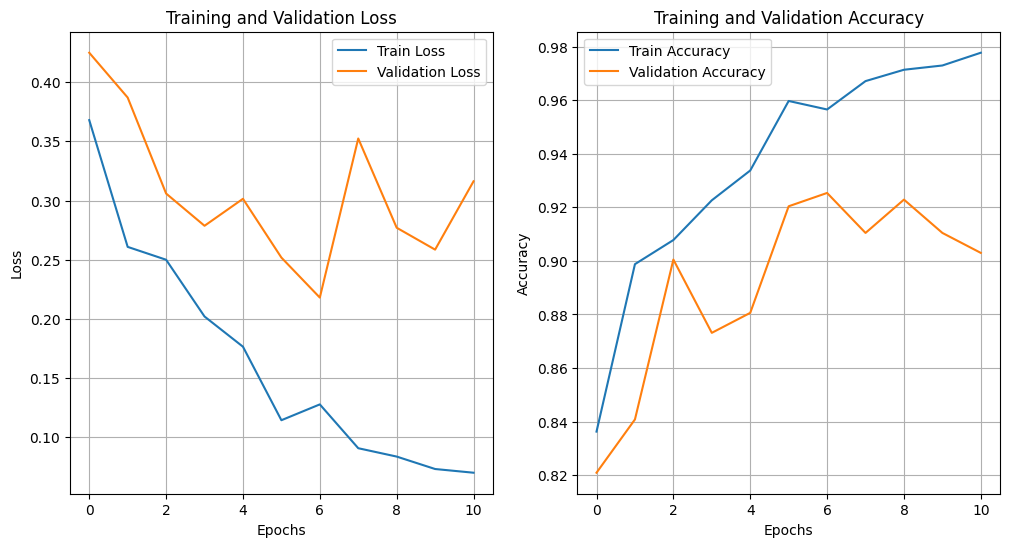

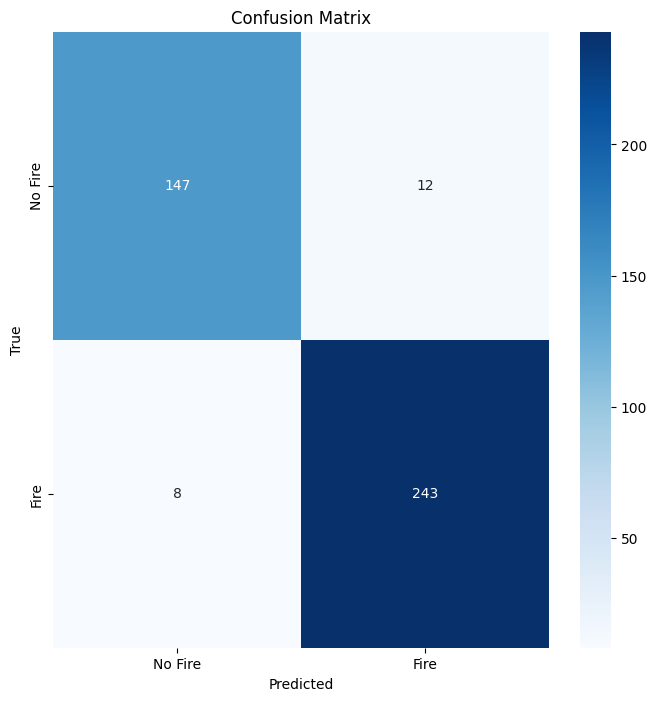

In [13]:
# Plots
plot_training(history, f"outputs/plots/{model_name}_training_curve.png")
plot_confusion_matrix(
    metrics["confusion_matrix"], 
    ["No Fire", "Fire"], 
    output_path=f"outputs/plots/{model_name}_confusion_matrix.png"
)
if "y_true" in metrics and "y_probs" in metrics:
    y_true = metrics["y_true"]
    y_probs = [prob[1] for prob in metrics["y_probs"]]
    plot_precision_recall(y_true, y_probs, f"outputs/plots/{model_name}_precision_recall_curve.png")
    plot_roc_curve(y_true, y_probs, f"outputs/plots/{model_name}_roc_curve.png")

print("[INFO] Final results saved successfully!")